

# Statistics
## Yoav Ram

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import scipy.special as spec
import statsmodels.api as sm
from statsmodels.formula.api import ols,
import urllib.request
import os.path
import zipfile
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
np.random.seed(847)

Some of the presented exercises follow the book [IPython Cookbook](http://ipython-books.github.io/cookbook/) by [Cyrille Rossant](http://cyrille.rossant.net/).

## Probability mass function (PMF) and hypothesis testing

**A Probability Mass Function** (*PMF*) is a mathematical function that describes the probability of a *discrete* random variables to take specific values. For each possible outcome in a discrete set, the PMF assigns a probability, indicating how probable that specific outcome is. 
*Note that all the values of the PMF must be nonegative and sum to 1!*

Example: A random variable which can take on the values 1,3, and 7. 

![general](https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Discrete_probability_distrib.svg/330px-Discrete_probability_distrib.svg.png)


### Binomial random variable
A binomial random variable represents the number of successes (usually denoted as `x`) in a fixed number of independent and identical experiments (`n`), each with only two possible outcomes: success or failure. The probability of success is usually denoted by `p`.  
The PMF gives the probability of obtaining a specific number of successes (`k`) in a fixed number of independent and identical experiments.

The formula for the PMF of a binomial random variable is:

![formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/b872c2c7bfaa26b16e8a82beaf72061b48daaf8e)
![nk](https://wikimedia.org/api/rest_v1/media/math/render/svg/d33401621fb832dd2f9783e80a906d562f669008)
Possible values range from 0 to `n`.

#### **Coin flip example:** 

Imagine tossing a coin with a probability q of landing on heads. When we toss the coin n times, the count of heads (x) out of the n tosses becomes a random binomial variable!

Let's write a function that flips a coin `n` times and returns the number of times it landed on *head*. It's a special coin - the probability that it falls on *head* is `q`:


In [2]:
def flip(n, q):
    #np.random.seed(3)
    randoms = np.random.random(n) #Generate n random uniform numbers over the interval [0.0, 1.0)
    heads = randoms < q # Create a boolean array
    return heads.sum()

Let's use this function:

In [3]:
n = 100
q = 0.56
x = flip(n, q=q)
x

61

## One sample mean hypothesis tests

Say we don't know what `q` is and we want to check if the coin is fair - that is, if `q` is 0.5. We can use a *hypothesis test* for this purpose. 

Our *null hypothesis* is $H_0: q=0.5$, whereas our alternative hypothesis is $H_A: q \ne 0.5$.

So we create a binomial random variable according to our null hypothesis, and we calculate the probability to get the result `x` or anything **more extreme** using the PMF under `H0`. 

In [4]:
q0 = 0.5
H0 = scipy.stats.binom(n, q0) # binomial random variable under the null hypothesis

Let's create a plot for the Probability Mass Function (PMF) of the random variable under the null hypothesis using the pmf function from the scipy library:

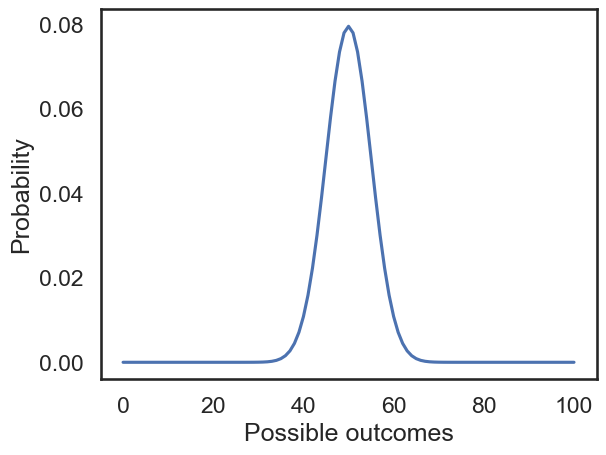

In [6]:
k = np.arange(0, n+1) # numbers from 0 to n
plt.plot(k, H0.pmf(k))
plt.xlabel('Possible outcomes')
plt.ylabel('Probability');

Let's enhance this visual representation. We'll include our observed count (`x`) in the plot and examine the question- how extreme is our observation under the null hypothesis $H_0$ 

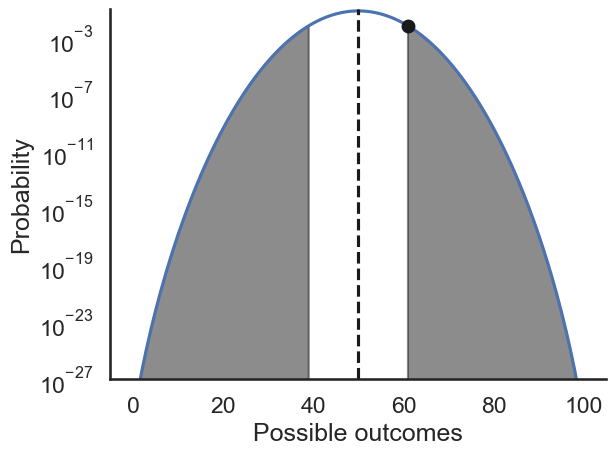

In [7]:

k = np.arange(0, n+1) # numbers from 0 to n

# plot probability of each possible result if null hypothesis is true
plt.plot(k, H0.pmf(k)) 
# Add a black circular marker to indicate the probability associated with our observation (x) if null hypothesis is true
plt.plot(x, H0.pmf(x), 'ok') # 'ok'-> black circular marker
# Adding a dashed line indicating the outcome with highest probability if null hypothesis is true
plt.axvline(n*q0, ls='--', color='k') 
# fill area of results as or less likely then observation
plt.fill_between(k[k>=x], H0.pmf(k[k>=x]), color='k', alpha=0.5)
plt.fill_between(k[k<=n*q0-(x-n*q0)], H0.pmf(k[k<=n*q0-(x-n*q0)]), color='k', alpha=0.5)

plt.ylim(1e-27, 1e-1)
plt.yscale('log') #A logarithmic scale is applied solely for visualization purposes. To view the data in its original scale, you can comment out this line of code.
plt.xlabel('Possible outcomes')
plt.ylabel('Probability')
sns.despine()

Now let's calculate the p-value manually:

In [8]:
# probability of results as or less likely then observation
low_tail = H0.pmf(k[k<=n*q0-(x-n*q0)]) 
high_tail = H0.pmf(k[k>=x])
# sum of these results is the p-value
#p-value = probability to get this observation or worse if null hypothesis is true
pvalue = low_tail.sum() + high_tail.sum()
print(f'pvalue = {pvalue}')

pvalue = 0.03520020021770479


Instead of doing the p-value calculation yourself, you can use scipy.stats.binom_test. This handy function in the SciPy library tests whether the probability of success in a Bernoulli experiment equals a specified probability (q0).

In [9]:
pval = scipy.stats.binom_test(x, n=n, p=q0)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(pval, pval < 0.05))

P-value: 0.035, Reject null hypothesis: True


Therefore, the probability to get this result under the null hypothesis < 0.05 which is often considered an evident  to reject the null hypothesis.   

### Likelihood and maximum likelihood

Now let's run *many* experiments and compare their distribution to the $H_0$ distribution:

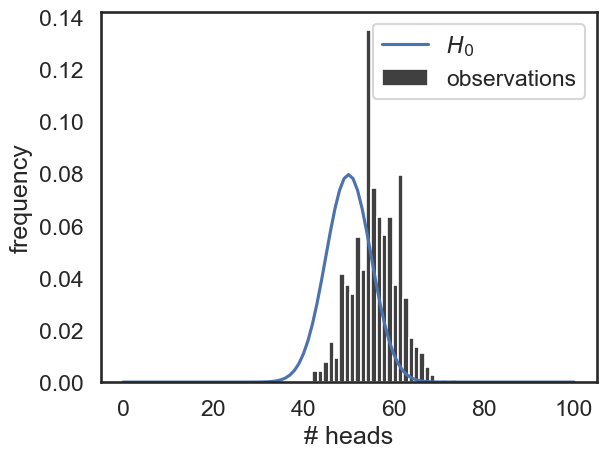

In [10]:
reps = 1000
nrange = range(0, n+1)
H0_pmf = H0.pmf(nrange) # Again, plot PMF of H0
xs = [flip(n, q) for _ in range(reps)] #generate many coin flip experiments
sns.histplot(xs, kde=False,  stat="density",label='observations', color = 'black') #Normalized hisotgram of experiment' distribution
plt.plot(nrange, H0_pmf, label='$H_0$')
plt.xlabel('# heads')
plt.ylabel('frequency')
plt.legend();


Assuming we don't know the exact `q`, just by looking at the histogram, it seems unlikely that q is 0.5 (as in the null hypothesis). We'd expect `q` to be a bit larger.


What's the probability of getting this specific set of observations with `q` values of 0.5, 0.52, 0.54, or 0.56? In this context, we refer to this probability as the **likelihood**.


To determine the true value of `q`, we can assess the likelihood of obtaining our observed outcomes for various `q` values. The `q` parameter that yields the maximum likelihood among these values will serve as our estimation.

So, how do we compute the likelihood of obtaining our observations given a particular q value? Because our experiments are independent, the probability of getting all the observations is the product of the probability of obtaining each observation. In other words, it's the product of the Probability Mass Function (PMF) values across all the observations.

Let's begin by computing the likelihood of obtaining our observations for `q`=0.5, corresponding to the q value under the null hypothesis $H_0$:

In [11]:
likelihood_H0 = H0.pmf(xs).prod()
print(likelihood_H0)

0.0


We got zero!! But we didn't have any zeros:

In [12]:
(H0.pmf(xs)==0).any() #Test whether any array element along a given axis evaluates to True

False

This is because some of these likelihoods are **very low**. 
When you multiply very small numbers in Python, the result can become zero due to *numerical precision limitations*.
In Python, floating-point numbers are represented using a finite number of bits, and there is a limit to how small a positive non-zero number can be represented. 


Lets plot the likelihoods given each of the $x$ values in `xs`.

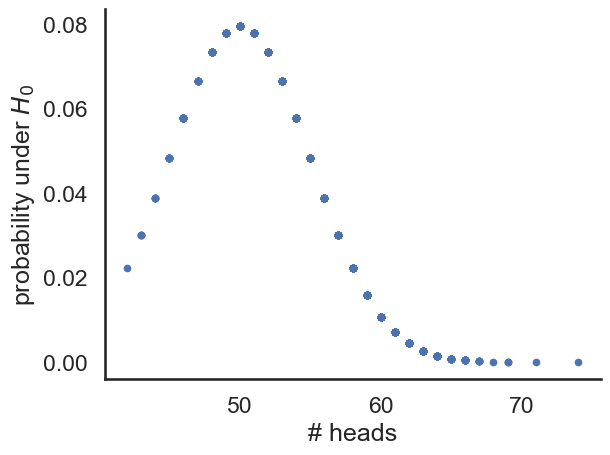

In [13]:
plt.plot(xs, H0.pmf(xs), '.')
plt.xlabel('# heads')
plt.ylabel('probability under $H_0$')
sns.despine()

A nice trick to solve this zero-from-non-zeros is to use the log-pmf and calculate the sum of log-likelihoods, which equals the log of product of likelihoods:
$$
\log\big(\prod_i{P(x_i)}\big) = \sum_i{\log\big(P(x_i)\big)}
$$

So the log-likelihood of H0 given all these data is:

In [14]:
H0.logpmf(xs).sum()

-3744.6624191782867


Now we calculate the likelihood for many possible $q$ values and plot them to find the most likely $q$.

In [15]:
def loglik(xs, q):
    r_binom = scipy.stats.binom(n, q)
    return r_binom.logpmf(xs).sum()

qs = np.linspace(0, 1, 100) # Trying different q values
logliks = np.array([loglik(xs, q) for q in qs])

most likely q=0.5556 (green)
real q=0.5600 (red)
null q=0.5000 (black)


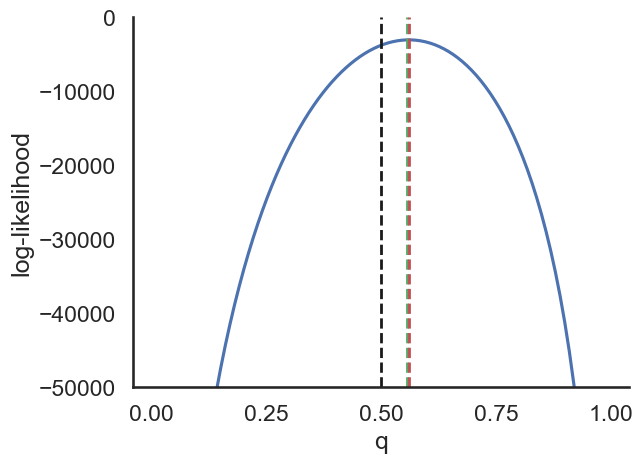

In [70]:
plt.plot(qs, logliks)
argmax = logliks.argmax() #The index of the best q value
plt.axvline(qs[argmax], ls='--', lw=2, color='g') # the maximum likelihood q value
plt.axvline(q0, ls='--', lw=2, color='k') # the q value associated with H0
plt.axvline(q, ls='--', lw=2, color='r') # the true q value
plt.ylim(0, 1)
plt.ylim(-50000, 0)
plt.xlabel('q')
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('log-likelihood')
sns.despine()

print('most likely q={:.4f} (green)'.format(qs[argmax]))
print('real q={:.4f} (red)'.format(q))
print('null q={:.4f} (black)'.format(q0))

This is the method of **maximum likelihood** and it works well: the most likely $q$ (green) is very close to the real $q$ (red) !

## Exercise

Consider `z`, an array of 50 experimental measurements.
We would like to use a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to test the null hypothesis that the expected/real value of the measurement is 75. 

Use the function `scipy.ttest_1samp` to calculate a P-value and make an hypothesis test (with a significance level of 0.05).

NormaltestResult(statistic=1.126778258696914, pvalue=0.5692764392536629)

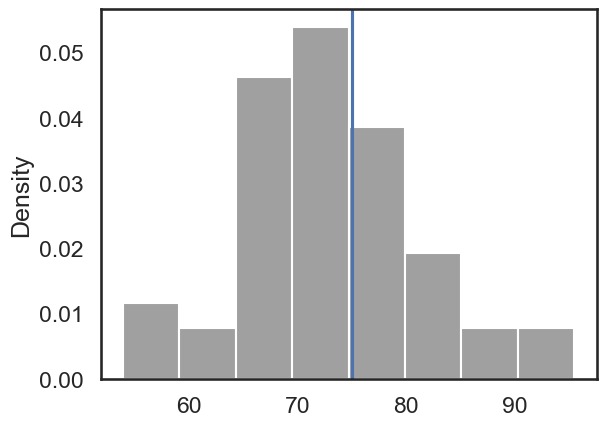

In [89]:
z = np.array([ 65.53023244,  72.23747986,  73.01265677,  89.9351998 ,
        70.6963815 ,  78.02590763,  81.2881422 ,  61.80569525,
        65.93705786,  70.54059758,  77.49758326,  68.42851182,
        68.55585283,  80.1871511 ,  74.65777598,  65.20851364,
        68.50039697,  65.90256468,  73.32305696,  74.03947153,
        77.1472388 ,  72.02604829,  82.7751142 ,  59.6132927 ,
        55.048079  ,  70.01523156,  90.5524559 ,  73.56715484,
        65.19466857,  76.66137409,  71.11086989,  58.7251773 ,
        53.9227519 ,  78.80348065,  65.70707516,  71.64598738,
        78.4655557 ,  68.55593575,  95.4389177 ,  65.28104808,
        79.67603416,  73.25855752,  67.59741922,  88.1492883 ,
        83.2779776 ,  80.9657968 ,  72.18488899,  76.23291307,
        76.50505861,  76.31360889])
sns.histplot(z, kde=False, stat="density", color = "grey")
plt.axvline(75)
scipy.stats.normaltest(z)

In [90]:
scipy.stats.ttest_1samp(z,75)

Ttest_1sampResult(statistic=-1.6412624075067797, pvalue=0.10714702731945416)

# Correlation, Anova and linear regression model 


We will use the *Iris dataset*, which consists of measurements from 150 iris flowers, representing three different species: setosa, versicolor, and virginica.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Iris_germanica_%28Purple_bearded_Iris%29%2C_Wakehurst_Place%2C_UK_-_Diliff.jpg/440px-Iris_germanica_%28Purple_bearded_Iris%29%2C_Wakehurst_Place%2C_UK_-_Diliff.jpg" width="200"/>


In [4]:
filename = '../data/iris_original.csv'
iris_data = pd.read_csv(filename)
iris_data.head()

,petal_length,petal_width,sepal_length,sepal_width,species
0,1.4,0.2,5.1,3.5,setosa
1,1.4,0.2,4.9,3.0,setosa
2,1.3,0.2,4.7,3.2,setosa
3,1.5,0.2,4.6,3.1,setosa
4,1.4,0.2,5.0,3.6,setosa


## Correlation tests 

<img src="https://files.realpython.com/media/py-corr-1.d13ed60a9b91.png" width="500"/>

Correlation tests are statistical methods used to assess the strength and direction of the relationship between two or more variables. These tests help to determine if there is a statistically significant association between the variables. Two common types of correlation tests include:

[*Pearson's linear correlation*](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)  (Pearson's r): Measures the linear relationship between two continuous variables. It ranges from -1 to 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no linear correlation.

[*Spearman Rank Correlation Coefficient*](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) (Spearman's rho): Assesses the monotonic relationship (whether the variables tend to increase or decrease together, but not necessarily at a constant rate) between two variables. It is less sensitive to outliers than Pearson's correlation.



Let's make a plot showing how petal length relates to petal width.

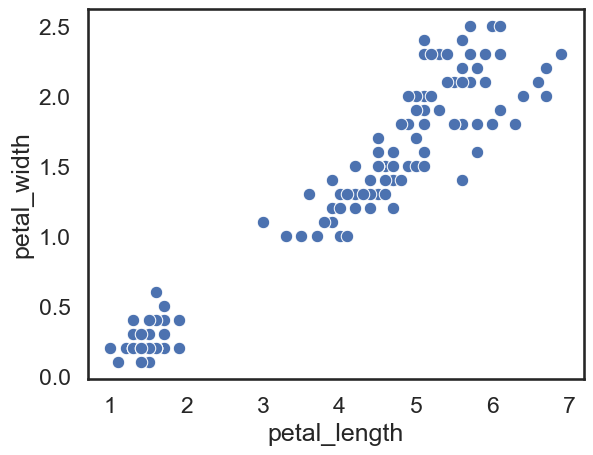

In [5]:

sns.scatterplot(x="petal_length",
                    y="petal_width",
                    #hue="species",
                    data=iris_data);


Looking at the plot, we can see that petal width and petal length are positively correlated!

Let's compute both the Pearson's and Spearman's correlation coefficients, along with their respective p-values, for the relationship between petal length and petal width.


In [7]:
pearson_r, pearson_pval = scipy.stats.pearsonr(iris_data['petal_length'],iris_data['petal_width'])
print(f"Pearson: r = {pearson_r}, p-value = {pearson_pval}")
spearman_r, spearman_pval = scipy.stats.spearmanr(iris_data['petal_length'],iris_data['petal_width'])
print(f"Spearman: r = {spearman_r}, p-value = {spearman_pval}")
# default method is "pearson"

Pearson: r = 0.962865431402796, p-value = 4.6750039073285846e-86
Spearman: r = 0.9376668235763412, p-value = 8.156596854126675e-70


**A strong positive connection is suggested by a correlation coefficient of 0.96 / 0.93.**
Now let's generate a 

              sepal_width  sepal_length  petal_width  petal_length
sepal_width      1.000000     -0.117570    -0.366126     -0.428440
sepal_length    -0.117570      1.000000     0.817941      0.871754
petal_width     -0.366126      0.817941     1.000000      0.962865
petal_length    -0.428440      0.871754     0.962865      1.000000


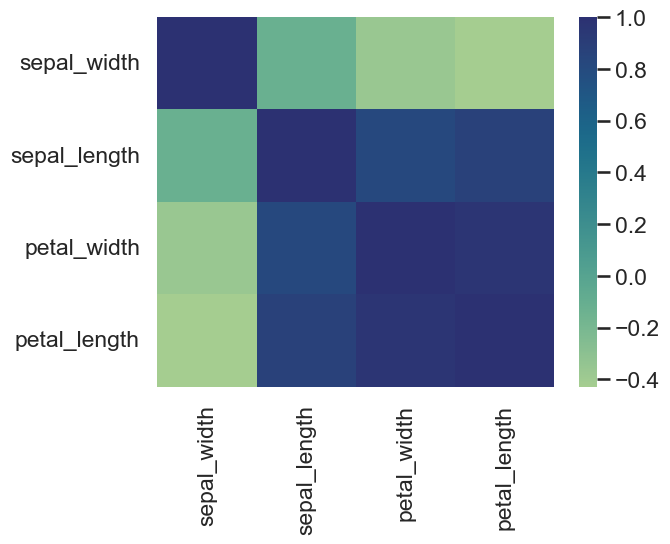

In [30]:
cormat = iris_data[["sepal_width","sepal_length","petal_width","petal_length"]].corr()
print(cormat)
sns.heatmap(cormat,cmap="crest");





## Anova


**ANOVA**, or Analysis of Variance, is a statistical test used to analyze the differences among group means in a sample. It assesses whether there are any statistically significant differences between the means of three or more independent (unrelated) groups.

*Normality assumption*: The residuals (the differences between observed and predicted values) should be approximately normally distributed. This assumption is more critical with smaller sample sizes.


Note that if we reject the null hypothesis, it doesn't indicate which particular group or groups differ from the others. To identify these differences, a post-hoc analysis is required.

Here, we want to see if the sepal widths of Setosa, Versicolor, and Virginica species are significantly different. To start, we'll use a boxplot to show how the sepal widths are spread in each group.


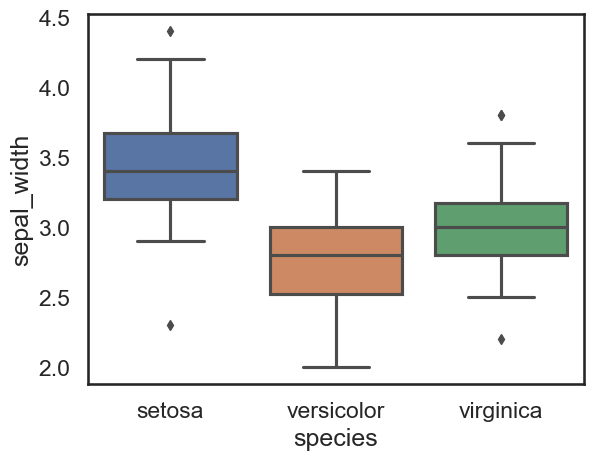

In [8]:
sns.boxplot(data=iris_data, x="species", y="sepal_width");

Now, we want to test if different species have significantly different sepal lengths using Anova: 

In [11]:

anova_ststistic,anova_p_val = f_oneway(sepal_width,versicolor_samples,virginica_samples)
print(f"Anova F-statistic: {anova_ststistic}, p-value {anova_p_val}")



Anova F-statistic: 49.160040089612075, p-value 4.492017133309115e-17
kruskal F-statistic: 63.571146104163795, p-value 1.5692820940316782e-14


In [59]:
model = ols('petal_length ~ C(species)', data=iris_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(species),437.1028,2.0,1180.161182,2.856777e-91
Residual,27.2226,147.0,NaN,NaN


Let's use a [QQ-plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot),  a graphical tool used in statistics to assess whether a dataset follows a particular theoretical distribution, such as a normal distribution in our case.

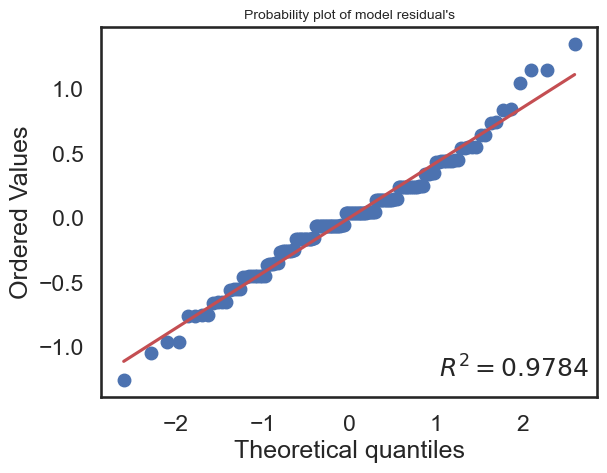

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)

normality_plot, stat = scipy.stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 10);

We can also use the [**Shapiro test for normality**](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) tests the null hypothesis that the observations come form a normal distribution.

In [61]:
print(scipy.stats.shapiro(model.resid))

ShapiroResult(statistic=0.9810755252838135, pvalue=0.03676711767911911)


By examining the QQ-plot and considering the p-value from the Shapiro test, we find evidence that the model's residuals are not normally distributed. As a result, we should use a non-parametric test.
The [**Kruskal-Wallis H-test**](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) is a *non-parametric* alternative to Anova. It tests the null hypothesis that the medians of different groups are the same. It's like a non-parametric version of ANOVA and works with two or more independent samples, even if their sizes are different. 

**Ex1** Use the kruskal implmentation in scipy.stats, and apply it to test the null hypothesis that the medians of Setosa, Versicolor and Virginica species are the same. Print the F statistic and the 

In [57]:
#Write your code here


kruskal F-statistic: 63.571146104163795, p-value 1.5692820940316782e-14


## Linear regerssion


Linear regression model asseses the relationship between a dependent variable and one or more explantory variables.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Linear_least_squares_example2.svg/440px-Linear_least_squares_example2.svg.png" width="200"/>

For example, let's look at the linear relationship between Sepal width and Sepal length:

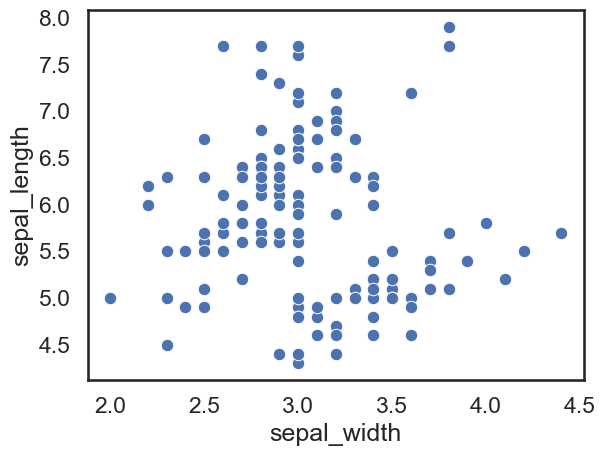

In [91]:
sns.scatterplot(x="sepal_width",
                    y="sepal_length",
                    #hue="species",
                    data=iris_data);

There isn't a clear linear relationship across all species. 
Let's define a linear model in which the dependent variable is the sepal length and the explanatory variable is sepal width. We can obtain a summary of the regression perfrmamcne, in a similar manner as in the R language.

In [144]:
model_0 = ols(formula="sepal_length ~ sepal_width", data=iris_data).fit()
#predictions = model.predict(X) 
model_0.summary() #print a summary of model performance


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sepal_length   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.074
Date:                Sun, 24 Dec 2023   Prob (F-statistic):              0.152
Time:                        16:45:07   Log-Likelihood:                -183.00
No. Observations:                 150   AIC:                             370.0
Df Residuals:                     148   BIC:                             376.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5262      0.479     13.628      0.000       5.580       7.473
sepal_width    -0.2234      0.155     -1.440      0.152      -0.530       0.083
==============================================================================
Omnibus:                        4.389   Durbin-Watson:                   0.952
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.237
Skew:                           0.360   Prob(JB):                        0.120
Kurtosis:                       2.600   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

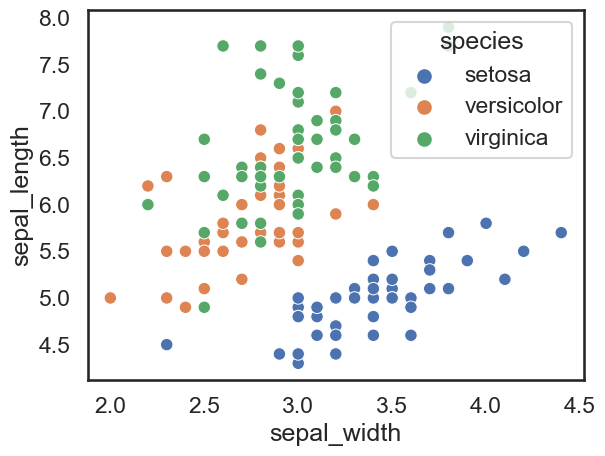

In [92]:
sns.scatterplot(x="sepal_width",
                    y="sepal_length",
                    hue="species",
                    data=iris_data);

OK, now we can see that within each species there is a linear relationship between sepal length and sepal width, Now let's generate a new model and this time include the species categorical variable.

In [161]:

model_1 = ols(formula="sepal_length ~ sepal_width+C(species)", data=iris_data).fit()
#predictions = model.predict(X) 
(model_1.summary()) #print a summary of model performance

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sepal_length   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     128.9
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           7.66e-41
Time:                        17:03:20   Log-Likelihood:                -86.968
No. Observations:                 150   AIC:                             181.9
Df Residuals:                     146   BIC:                             194.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.2514      0.370      6.089      0.000       1.521       2.982
C(species)[T.versicolor]     1.4587      0.112     13.012      0.000       1.237       1.680
C(species)[T.virginica]      1.9468      0.100     19.465      0.000       1.749       2.144
sepal_width                  0.8036      0.106      7.557      0.000       0.593       1.014
==============================================================================
Omnibus:                        7.510   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.629
Skew:                           0.423   Prob(JB):                       0.0221
Kurtosis:                       3.710   Cond. No.                         36.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we obtained a relatively high R^2, and both the sepal width and species obtained very small p-values, indicating they should be included in the model!

**Ex1**: Generate a **residuals plot** using the sepal width as the independent variable (note that this is not a QQ-plot , and that both should be examined to make sure model assupmtions are correct).

What is a residual plot?
A residual plot displays the differences between actual and predicted values on the vertical axis, with the independent variable(s) on the horizontal axis. In a good linear regression model, you'd want residuals to be randomly spread around zero without any noticeable pattern. However, patterns like a funnel shape or clear curvature in the plot could suggest issues with consistent variability (homoscedasticity) or linearity in the model.

Help: take a look at the QQ-plot example in the Anova section to see how we extract the model residuals.

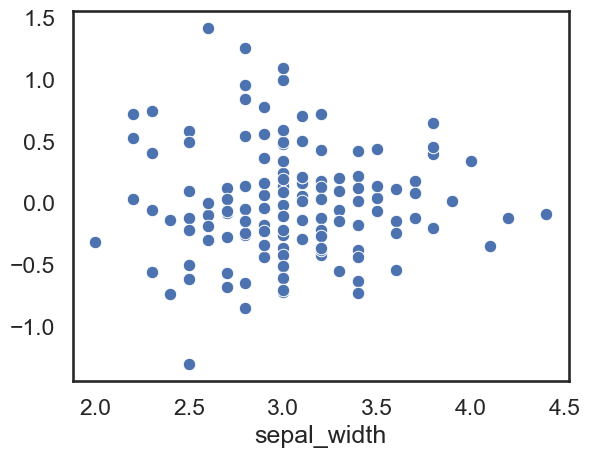

In [174]:
sns.scatterplot(x=iris_data["sepal_width"],
                    y=model_1.resid,
                    );

Now let's also add petal length and petal width to the model, and see if we improve the R^2.

In [162]:
model_2 = ols(formula="sepal_length ~ sepal_width+C(species)+petal_length+petal_width", data=iris_data).fit()
#predictions = model.predict(X) 
print(f'R^2 = {np.round(model_2.rsquared,2)}') #print a summary of model performance

R^2 = 0.87


The R^2 improved, again! However, to test if the addition of these variables to the model is significant, we should use an [F test](https://en.wikipedia.org/wiki/F-test).

In [168]:
print(model_2.compare_f_test(model_1))

(76.73057891940888, 2.0659529126942097e-23, 2.0)


We obtained a sifnificant result, indicating that the richer model (which includes the new variables) is better.
 
We should remember that higher R^2 does not necessarily indicate a better model.

**Ex2**: As an experiment, try to add 50 random variables to the model and see if R^2 improves.

In [157]:
#Write your code here

R^2 = 0.9


It turns out that adding non-relevant variables to the model can only **increase** the R^2, which means we should not use R^2 as a metric to choose between models. In case of nested models, we should use an F-test. For non-nested models we can use [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) or [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion), which penalize models for high number of parameters.

# Estimating distributions

SciPy has builtin functions to estimate probability distributions from data using [*Maximum Likelihood Estimators*](http://en.wikipedia.org/wiki/Maximum_likelihood) (MLE).

Let's load some transplant survival data (originally from *Miller, R. (1976). Least squares regression with censored dara. Biometrica, 63 (3). 449-464*). This data contains the survival time after receiving a heart transplant.

In [73]:
df = pd.read_csv('../data/heart.csv')
df.head()

,survival
0,15.0
1,3.0
2,624.0
3,46.0
4,127.0


We start by plotting the survival data for each patient, by descending survival, and the histogram of the survival data.

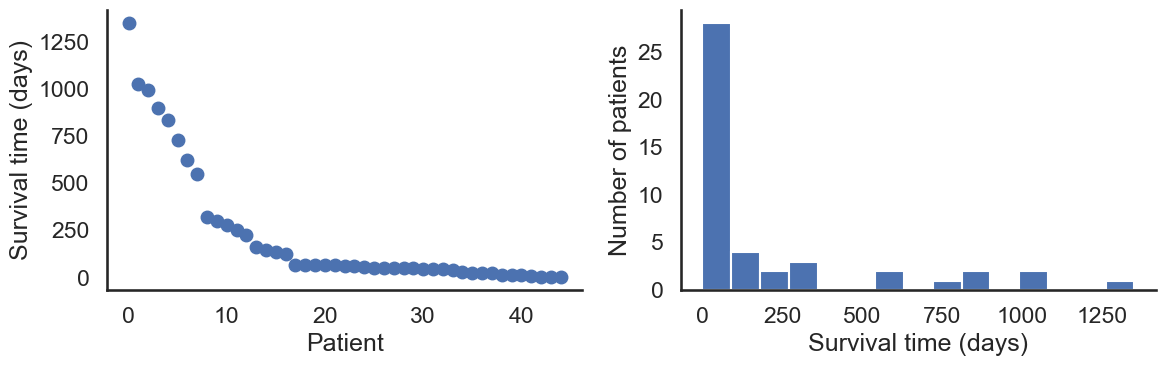

In [75]:
survival = df.survival

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(sorted(survival)[::-1], 'o')
ax[0].set(xlabel='Patient', ylabel='Survival time (days)')

ax[1].hist(survival, bins=15)
ax[1].set(xlabel='Survival time (days)', ylabel='Number of patients')

fig.tight_layout()
sns.despine()

It seems that the histogram is decreasing rapidly (this is data from the 1970s), so we will try to fit an *exponential distribution* to the data.

We do this using the `scipy.stats.expon` class which has a `fit` class method (as do all the continous distribution classes).
This function finds the most likely parameters for the distribution and returns the distribution paramters (the location and scale, in this case).

In [76]:
params = scipy.stats.expon.fit(survival)
print(params)

(1.0, 222.2888888888889)


If we want to plot the histogram with a fitted distribution, we can just use Seaborn:

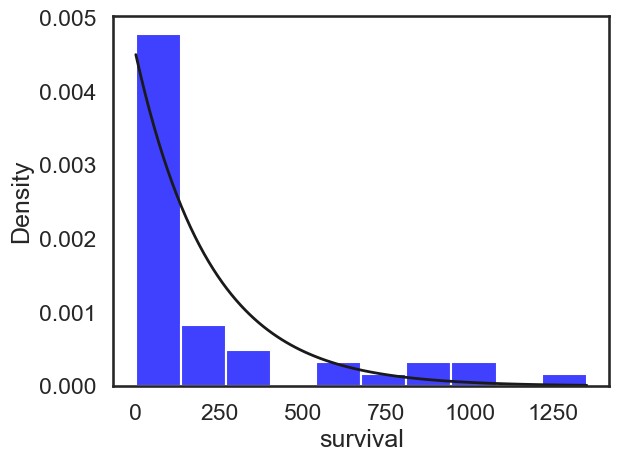

In [87]:
sns.histplot(survival, bins=10, kde=False, stat='density', color='blue')

# Overlay the fitted exponential distribution
xmin, xmax = np.min(survival), np.max(survival)
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.expon.pdf(x, *params) # Apply the exponential fit
plt.plot(x, p, 'k', linewidth=2)

# Show the plot
plt.show()

This doesn't look that good. A statistical test for the fit of the distribution to the data (a statistical quantification to the statement "this doesn't look that good") can be done with the [Kolmogorov-Smirnov goodness of fit test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test) implemented in the `scipy.stats.kstest` function. The null hypothesis in this case is that the data came from the estimated exponential distribution.

In [35]:
fitted_expon = scipy.stats.expon(*params)
D, p = scipy.stats.kstest(survival, fitted_expon.cdf)
print("Exponential distribution")
print("P-value: {0:.2g}, reject null hypothesis: {1}".format(p, p < 0.05))

Exponential distribution
P-value: 8.6e-06, reject null hypothesis: True


Indeed, we reject the null hypothesis - the exponential distribution is unlikely for this dataset.

## Exercise

Let's try a different distribution, the [fatigue life distribution](https://en.wikipedia.org/wiki/Birnbaum%E2%80%93Saunders_distribution), used extensively in reliability applications to model failure times.

Fit the distribution to the data, test it with the `kstest`, and plot it with the data and the exponential distribution for comparison.

**Note** the fatigue-life distribution has three parameters whereas the exponential distribution has two, so we should probably use another statistical method to decide on the correct model, such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

# Kernel density estimation

Sometimes we don't have an idea as to what is the *real* distribution of the data.
In these cases we can perform non-parameteric estimation to fit an arbitrary family of function to the data distribution. 

Here, we use a [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE).
For example, Seaborn will automatically use KDE with a gaussian kernel if we use `distplot`:

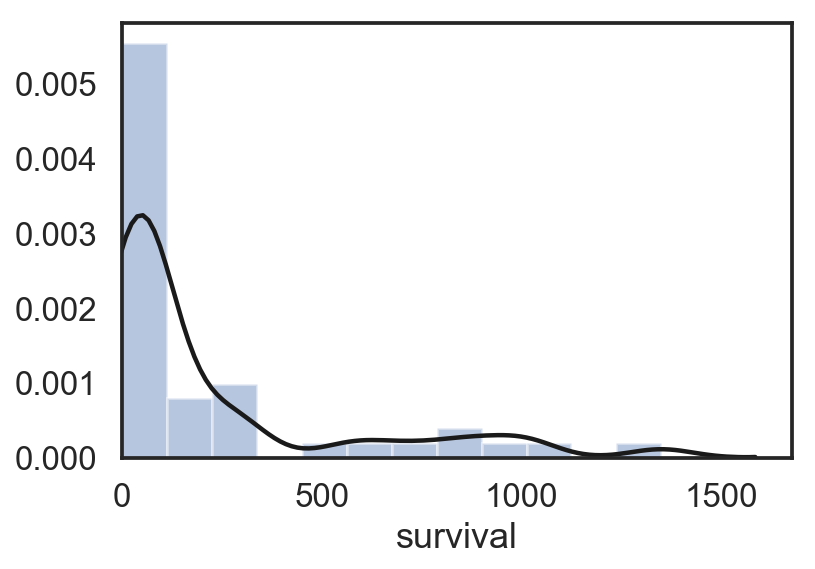

In [36]:
sns.distplot(survival, kde_kws=dict(color='k'))
plt.xlim(0, None);

How is this done?

For a histogram, 
- the horizontal axis is divided into bins that cover the range of the data.
- (here, we have 6 bins each of width 2, from -4 to 8.)
- when a value falls inside a bin, we place a box of height `1/(bins*width)` (here 1/12~0.83).
- if more than one value falls inside the same bin, we stack the boxes on top of each other.

In [37]:
x = np.array([-2.1, -1.3, -0.4, 1.9, 5.1, 6.2])
n = x.size

bins = range(-4, 10, 2)

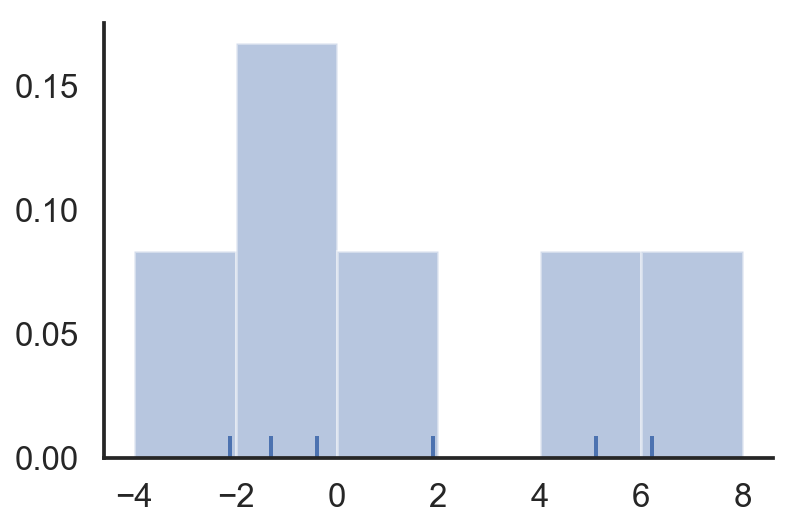

In [38]:
sns.distplot(x, bins, kde=False, rug=True, rug_kws=dict(lw=2), norm_hist=True)
plt.xticks(bins)
plt.xlim(-4.6, 8.6)
sns.despine()

For the kernel density estimate, 
- we place a (normal) kernel with variance $\sigma^2$ (red lines) on each of the values `x[i]`.
- the kernels are summed to make the kernel density estimate (black line).

The $\sigma$ parameter is related to the bandwith parameter `h`, which is a free parameter.

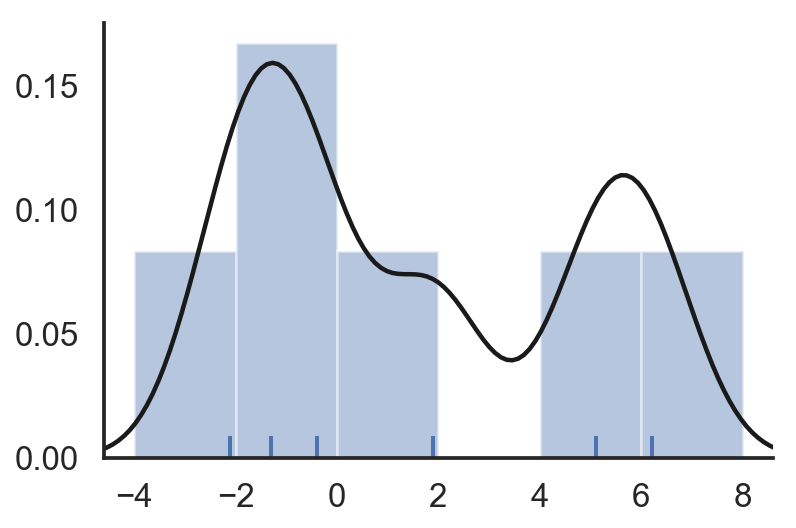

In [40]:
sns.distplot(x, bins, kde=True, rug=True, rug_kws=dict(lw=2), norm_hist=True, 
             kde_kws=dict(bw=σ, color='k'))
plt.xticks(bins)
plt.xlim(-4.6, 8.6)
sns.despine()

# References

- [IPython Cookbook](http://ipython-books.github.io/cookbook/): IPython Interactive Computing and Visualization Cookbook by Cyrille Rossant.
- [scipy.stats tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
- [Scipy's statistical functions](http://docs.scipy.org/doc/scipy/reference/stats.html)
- [Visualizing distributions in Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html)
- [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) on Wikipedia

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)